In [19]:
import pandas as pd
from drug_utils import DataHandler

In [20]:
import json

# Path to your JSON Lines file
file_path = 'processed_data2.json'

# Initialize an empty list to store all uses
all_uses = []

# Open the file and read line by line
with open(file_path, 'r') as file:
    # Skip the first line as it's just the opening bracket '['
    next(file)
    
    # Read each line in the file
    for line in file:
        # Check if the line is just the closing bracket ']'
        if line.strip() == ']':
            break
        
        # If there is a comma at the end of the line (except for the last JSON object),
        # remove it to properly parse the JSON object
        if line.endswith(',\n'):
            line = line[:-2]
        
        # Parse the JSON object
        drug = json.loads(line)
        
        # Add the 'uses' to the all_uses list
        all_uses.extend(drug['uses'])

# Remove duplicates by converting the list to a set, then back to a list
unique_uses = list(set(all_uses))

# Output the list of unique uses
unique_uses.sort()


In [21]:
uses_dictionary = {}
for use in unique_uses:
    uses_dictionary[use] = []

with open('processed_data2.json', 'r') as file:
    drugs_data = json.load(file)


In [22]:
for drug in drugs_data:
    for use in drug['uses']:
        if use in uses_dictionary.keys():
            uses_dictionary[use].extend(drug['drug_classes'])

for use, lst in uses_dictionary.items():
    uses_dictionary[use] = list(set(lst))


In [23]:
with open('categorized_conditions_reversed.json', 'r') as file:
    classification = json.load(file)
pairs = [(drug, condition) for condition, drugs in uses_dictionary.items() for drug in drugs if classification[condition] != 'Treatments']

# Creating DataFrame
df = pd.DataFrame(pairs, columns=['Drug_class', 'condition'])
df

,Drug_class,condition
0,Antiviral combinations,AIDS Dementia Complex
1,Plasma expanders,Abdominal Infection
2,Herbal products,Abdominal Pain
3,GI stimulants,Abdominal Pain
4,Mast cell stabilizers,Abdominal Pain
...,...,...
5356,Immune globulins,varicella zoster
5357,Miscellaneous central nervous system agents,vasomotor symptom
5358,Miscellaneous coagulation modifiers,von Willebrand Disease
5359,Antidiuretic hormones,"von Willebrand Disease, Type 3"


In [24]:
classification_counts = df.groupby(['Drug_class', 'condition']).size().reset_index(name='Count')
classification_counts.sort_values(by='Count', ascending=False, inplace=True)
classification_counts

,Drug_class,condition,Count
0,5-alpha-reductase inhibitors,Alopecia,1
3581,Nutraceutical products,Peripheral Arterial Diseases,1
3579,Nutraceutical products,Pain management,1
3578,Nutraceutical products,Pain in lower limb,1
3577,Nutraceutical products,Pain,1
...,...,...,...
1786,H. pylori eradication agents,Gastric ulcer,1
1785,H. pylori eradication agents,Duodenal Ulcer,1
1784,H. pylori eradication agents,Communicable Diseases,1
1783,Guanylate cyclase-C agonists,Symptoms,1


In [25]:
binary_matrix = pd.pivot_table(df, index='condition', columns='Drug_class', aggfunc=len, fill_value=0)
binary_matrix

Drug_class,5-alpha-reductase inhibitors,5-aminosalicylates,5HT3 receptor antagonists,ACE inhibitors with calcium channel blocking agents,ACE inhibitors with thiazides,AMPA receptor antagonists,Adamantane antivirals,Adrenal corticosteroid inhibitors,Adrenergic bronchodilators,Adrenergic uptake inhibitors for ADHD,...,VMAT2 inhibitors,Vaccine combinations,Vaginal anti-infectives,Vasodilators,Vasopressin antagonists,Vasopressors,Viral vaccines,Viscosupplementation agents,Vitamin and mineral combinations,Vitamins
condition,,,,,,,,,,,,,,,,,,,,,
AIDS Dementia Complex,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Abdominal Infection,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Abdominal Pain,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Abdominal wind pain,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Abducens Nerve Diseases,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
varicella zoster,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
vasomotor symptom,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
von Willebrand Disease,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# Import necessary library
from sklearn.decomposition import TruncatedSVD
# Assuming 'binary_matrix' is your DataFrame
total_features = binary_matrix.shape[1]

# Setting n_components_high to a fraction of total features
# For example, half of the total features, but ensuring it's less than the total
n_components_high = min(total_features // 2, total_features - 1)

svd = TruncatedSVD(n_components=n_components_high)
svd.fit(binary_matrix)

# Calculate cumulative explained variance
cumulative_variance = svd.explained_variance_ratio_.cumsum()

# Find the number of components for a desired total variance, e.g., 95%
desired_variance = 0.95
optimal_n_components = sum(cumulative_variance < desired_variance) + 1
optimal_n_components

/Users/David/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/David/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/David/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


197

/Users/David/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/David/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/David/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


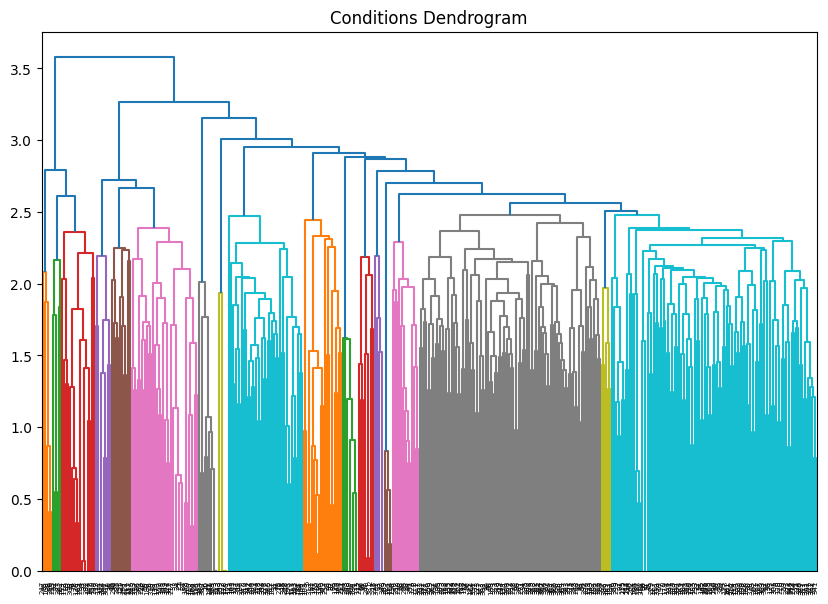

In [27]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import TruncatedSVD
# Creating a binary matrix using a pivot table
binary_matrix = pd.pivot_table(df, index='Drug_class', columns='condition', aggfunc=len, fill_value=0)
n_components = optimal_n_components  # Example value, adjust based on your needs

# Create and fit the model
svd = TruncatedSVD(n_components=n_components)
reduced_matrix = svd.fit_transform(binary_matrix)

# Computing similarity
similarity_matrix = cosine_similarity(reduced_matrix)

# Plotting the dendrogram to help decide the number of clusters
plt.figure(figsize=(10, 7))
plt.title("Conditions Dendrogram")
dendrogram = sch.dendrogram(sch.linkage(similarity_matrix, method='average'))
plt.show()


In [28]:
# Clustering with a specified number of clusters
cluster = AgglomerativeClustering(n_clusters = 9, affinity='cosine', linkage='average')
cluster_labels = cluster.fit_predict(similarity_matrix)

# Create a new DataFrame for cluster labels
drug_classes = binary_matrix.index
clustered_df = pd.DataFrame({'Drug_class': drug_classes, 'Cluster': cluster_labels})

# Viewing conditions in each cluster
clustered_df = clustered_df.sort_values(by='Cluster')
cluster_dict = {}
for cluster_num in sorted(clustered_df['Cluster'].unique()):
    cluster_dict[f"Cluster {cluster_num}"] = clustered_df[clustered_df['Cluster'] == cluster_num]['Drug_class'].tolist()
    print(f"Cluster {cluster_num}:")
    print(cluster_dict[f"Cluster {cluster_num}"], "\n")

Cluster 0:
['Local injectable anesthetics', 'Neuromuscular blocking agents', 'Neuraminidase inhibitors', 'Natural penicillins', 'Nasal steroids', 'Nasal lubricants and irrigations', 'Nasal antihistamines and decongestants', 'Narcotic analgesic combinations', 'NK1 receptor antagonists', 'Neuronal potassium channel openers', 'NHE3 inhibitors', 'Mucolytics', 'Mouth and throat products', 'Monoamine oxidase inhibitors', 'Mitotic inhibitors', 'Miscellaneous vaginal agents', 'Miscellaneous uncategorized agents', 'Miscellaneous topical agents', 'Miscellaneous respiratory agents', 'Multikinase inhibitors', 'Next generation cephalosporins', 'Nicotinic acid derivatives', 'Non-cardioselective beta blockers', 'PCSK9 inhibitors', 'PARP inhibitors', 'Oxazolidinone antibiotics', 'Otic steroids with anti-infectives', 'Otic steroids', 'Otic anti-infectives', 'Other immunosuppressants', 'Other immunostimulants', 'Other cephalosporins', 'Oral nutritional supplements', 'Opioids (narcotic analgesics)', 'Oph

In [29]:
import pandas as pd

# Assuming you have a list or array of drug classes named 'drug_classes'
# And each drug class corresponds to an element in 'cluster_labels'

# Create a DataFrame from drug classes and cluster labels
df_clusters = pd.DataFrame({'Drug_class': drug_classes, 'Cluster': cluster_labels})

# Merge this with the original DataFrame
df_clustered = pd.merge(df, df_clusters, on='Drug_class', how='left')

# Now df_clustered will have the original data along with the cluster labels for each drug class


In [30]:
df_clustered

,Drug_class,condition,Cluster
0,Antiviral combinations,AIDS Dementia Complex,0
1,Plasma expanders,Abdominal Infection,0
2,Herbal products,Abdominal Pain,0
3,GI stimulants,Abdominal Pain,0
4,Mast cell stabilizers,Abdominal Pain,0
...,...,...,...
5356,Immune globulins,varicella zoster,0
5357,Miscellaneous central nervous system agents,vasomotor symptom,0
5358,Miscellaneous coagulation modifiers,von Willebrand Disease,0
5359,Antidiuretic hormones,"von Willebrand Disease, Type 3",3


In [31]:
import pandas as pd

# Assuming your classification dictionary looks something like this:
# classification = {'condition1': 'disease_type1', 'condition2': 'disease_type2', ...}

# Convert the classification dictionary to a DataFrame
classification_df = pd.DataFrame(list(classification.items()), columns=['condition', 'Use_Type'])



In [32]:
# Merge with df_clustered
# Assuming df_clustered has a column 'Condition' that matches the keys in the classification dictionary
df_clustered_with_disease_type = pd.merge(df_clustered, classification_df, on='condition', how='left')


In [33]:
import pandas as pd

# Step 1: Calculate the frequency of each disease type per cluster
disease_cluster_counts = df_clustered_with_disease_type.groupby(['Cluster', 'Use_Type']).size()

# Step 2: Calculate the total number of conditions per cluster
cluster_counts = df_clustered_with_disease_type['Cluster'].value_counts()

# Step 3: Compute conditional probabilities
# Convert cluster_counts to a DataFrame for easy division
cluster_counts_df = cluster_counts.to_frame(name='Total_Count')

# Calculate conditional probabilities
conditional_probabilities = disease_cluster_counts.div(cluster_counts_df['Total_Count'], level='Cluster')

# Reshape for better readability
conditional_probabilities_df = conditional_probabilities.reset_index(name='Conditional_Probability')

# Display the conditional probabilities
conditional_probabilities_df


,Cluster,Use_Type,Conditional_Probability
0,0,Allergies and Immune Disorders,0.008572
1,0,Autoimmune Disorders,0.010715
2,0,Cardiovascular Diseases,0.094681
3,0,Chronic Conditions,0.005455
4,0,Deficiency Disorders,0.007208
...,...,...,...
112,8,Metabolic,0.153846
113,8,Neurological Disorders,0.384615
114,8,Nutritional and Dietary,0.076923
115,8,Respiratory Diseases,0.153846


In [34]:
top_3_per_cluster = conditional_probabilities_df.groupby('Cluster').apply(
    lambda x: x.nlargest(3, 'Conditional_Probability')
).reset_index(drop=True)
top_3_per_cluster

,Cluster,Use_Type,Conditional_Probability
0,0,Infectious Diseases,0.104228
1,0,Neurological Disorders,0.100331
2,0,Cardiovascular Diseases,0.094681
3,1,Ophthalmological Disorders,0.384615
4,1,Neurological Disorders,0.102564
5,1,Endocrine Disorders,0.076923
6,2,Endocrine Disorders,0.558140
7,2,Nutritional and Dietary,0.186047
8,2,Hematological Disorders,0.046512
9,3,Dermatological,0.200000


In [35]:
with open('condition_clusters.json', 'w') as file:
    json.dump(cluster_dict, file, indent=4)

In [36]:
with open('categorized_conditions.json', 'r') as file:
    data = json.load(file)

reversed_dict = {}
for category, diseases in data.items():
    for disease in diseases:
        reversed_dict[disease] = category

# Now reversed_dict will have diseases as keys and their categories as values.
with open('categorized_conditions_reversed.json', 'w') as file:
    json.dump(reversed_dict, file, indent=4)